In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

from Bio.PDB import PDBParser
import py3Dmol

Step 1: Read the file 

In [101]:
# Initialize the PDB parser
parser = PDBParser()

# Parse the PDB file
structure = parser.get_structure("RNA_Structure", "data/157d.pdb")

# Extract information to verify loading
print(f"Structure ID: {structure.id}")
for model in structure:
    print(f"Model {model.id} has {len(model)} chains")


Structure ID: RNA_Structure
Model 0 has 2 chains


c:\Users\User\Downloads\Fall2024\CHEM4580\CHEM4580-Molecular-Informatics\CHEM4580-Project\.conda\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 816.
  warnings.warn(
c:\Users\User\Downloads\Fall2024\CHEM4580\CHEM4580-Molecular-Informatics\CHEM4580-Project\.conda\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 869.
  warnings.warn(


In [103]:
# Load the PDB file as a text string
with open("data/157d.pdb", "r") as file:
    pdb_data = file.read()

# Create the viewer
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")  # Add the model from the PDB data
view.setStyle({'stick': {}})  # Color carbon atoms green  
view.zoomTo()                   # Automatically zoom to fit the structure

# Show the viewer
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [104]:
# Create the viewer
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")  # Add the model from the PDB data

view.setStyle({'sphere': {'radius': 0.5}})  # Adjust the sphere radius

view.zoomTo()                   # Automatically zoom to fit the structure

# Show the viewer
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Step 1: Calculate Ribose Backbone Dihedral Angles (ν0 to ν4)

In [105]:
# Function to calculate the dihedral angle between four points
def dihedral(p1, p2, p3, p4):
    b1 = p2 - p1
    b2 = p3 - p2
    b3 = p4 - p3
    
    # Normalize b2 to avoid influence on angle magnitude
    b2 /= np.linalg.norm(b2)
    
    # Project b1 and b3 perpendicular to b2
    v = b1 - np.dot(b1, b2) * b2
    w = b3 - np.dot(b3, b2) * b2
    
    # Calculate the dihedral angle
    x = np.dot(v, w)
    y = np.dot(np.cross(b2, v), w)
    return np.degrees(np.arctan2(y, x))

# Extract dihedral angles ν0 to ν4 for each residue
dihedrals_data = []
for model in structure:
    for chain in model:
        for residue in chain:
            # Ensure the residue has the necessary atoms for each ν dihedral angle
            try:
                # Get coordinates for each ν angle
                v0 = dihedral(residue["C4'"].coord, residue["O4'"].coord, residue["C1'"].coord, residue["C2'"].coord)
                v1 = dihedral(residue["O4'"].coord, residue["C1'"].coord, residue["C2'"].coord, residue["C3'"].coord)
                v2 = dihedral(residue["C1'"].coord, residue["C2'"].coord, residue["C3'"].coord, residue["C4'"].coord)
                v3 = dihedral(residue["C2'"].coord, residue["C3'"].coord, residue["C4'"].coord, residue["O4'"].coord)
                v4 = dihedral(residue["C3'"].coord, residue["C4'"].coord, residue["O4'"].coord, residue["C1'"].coord)
                
                # Append the results
                dihedrals_data.append({
                    "Residue": residue.id[1],
                    "Chain": chain.id,
                    "ν0 (C4'-O4'-C1'-C2')": v0,
                    "ν1 (O4'-C1-'C2'-C3')": v1,
                    "ν2 (C1'-C2'-C3'-C4')": v2,
                    "ν3 (C2'-C3'-C4'-O4')": v3,
                    "ν4 (C3'-C4'-O4'-C1')": v4
                })
            except KeyError:
                # Skip residues missing any required atoms for these calculations
                continue

# Convert to DataFrame and display a preview
dihedrals_df = pd.DataFrame(dihedrals_data)
dihedrals_df.head()  # Display the first few rows to preview


,Residue,Chain,ν0 (C4'-O4'-C1'-C2'),ν1 (O4'-C1-'C2'-C3'),ν2 (C1'-C2'-C3'-C4'),ν3 (C2'-C3'-C4'-O4'),ν4 (C3'-C4'-O4'-C1')
0,1,A,-168.533600,144.592545,-134.703522,141.130859,-161.733414
1,2,A,-179.525894,157.636566,-144.863235,144.207504,-157.467728
2,3,A,-179.737686,155.898178,-142.897858,141.506500,-155.772995
3,4,A,176.812912,155.952835,-139.505234,135.521622,-149.885620
4,5,A,160.721649,168.149460,-144.396713,132.420135,-138.681641


In [ ]:
pdb_file = 'data/157d.pdb'

outfile = open(pdb_file, 'r')
data = outfile.readlines()
outfile.close()

for line in data:
    if 'SEQRES' in line: 
        SEQRES = line
        print(SEQRES)

SEQRES   1 A   12    C   G   C   G   A   A   U   U   A   G   C   G              

SEQRES   1 B   12    C   G   C   G   A   A   U   U   A   G   C   G              



In [106]:
# Save the complete data to a CSV file
csv_file_path = "ribose_backbone_dihedrals_v0_to_v4.csv"
dihedrals_df.to_csv(csv_file_path, index=False)

print(f"Dihedral angles data (ν0 to ν4) saved to {csv_file_path}")


Dihedral angles data (ν0 to ν4) saved to ribose_backbone_dihedrals_v0_to_v4.csv


Step 1: Define tan(P) and v(max) Calculations

In [107]:
# Load the ν dihedral angles from the previous calculation
dihedrals_df = pd.read_csv("ribose_backbone_dihedrals_v0_to_v4.csv")

# Function to calculate tan(P) and v(max) for each residue
def calculate_tanP_vmax(row):
    # Extract ν angles        
    v0 = row["ν0 (C4'-O4'-C1'-C2')"]
    v1 = row["ν1 (O4'-C1-'C2'-C3')"]
    v2 = row["ν2 (C1'-C2'-C3'-C4')"]
    v3 = row["ν3 (C2'-C3'-C4'-O4')"]
    v4 = row["ν4 (C3'-C4'-O4'-C1')"]
    
    # Calculate pseudorotation angle P using the formula from the paper

    tan_P = ((v4+v1)-v3+v0)/(2*v2*(np.sin(36)+np.sin(72)))
    P = np.arctan(tan_P)
    
    # Calculate v(max) as the maximum amplitude among the ν angles
    vmax = v2/(np.cos(P))
    
    return tan_P, vmax

# Apply the calculation to each row in the DataFrame
dihedrals_df[['tan(P)', 'v(max)']] = dihedrals_df.apply(calculate_tanP_vmax, axis=1, result_type='expand')

# Display a preview of the updated DataFrame with tan(P) and v(max)
dihedrals_df[['Residue', 'Chain', 'tan(P)', 'v(max)']].head()


,Residue,Chain,tan(P),v(max)
0,1,A,-1.643804,-259.180615
1,2,A,-1.513361,-262.768583
2,3,A,-1.522580,-260.303658
3,4,A,0.230010,-143.147917
4,5,A,0.271069,-149.607703


In [108]:
# Display the table preview in the notebook
dihedrals_df_preview = dihedrals_df[['Residue', 'Chain', 'tan(P)', 'v(max)']]
dihedrals_df_preview.head()  # Preview in the notebook

# Save to a CSV file for the full dataset
tanP_vmax_csv_path = "tanP_vmax_ribose_backbone.csv"
dihedrals_df.to_csv(tanP_vmax_csv_path, index=False)

print(f"tan(P) and v(max) data saved to {tanP_vmax_csv_path}")


tan(P) and v(max) data saved to tanP_vmax_ribose_backbone.csv


Step 2: Create the Circular Graph with tan(P) and v(max)
* Graph looks wrong, double check code

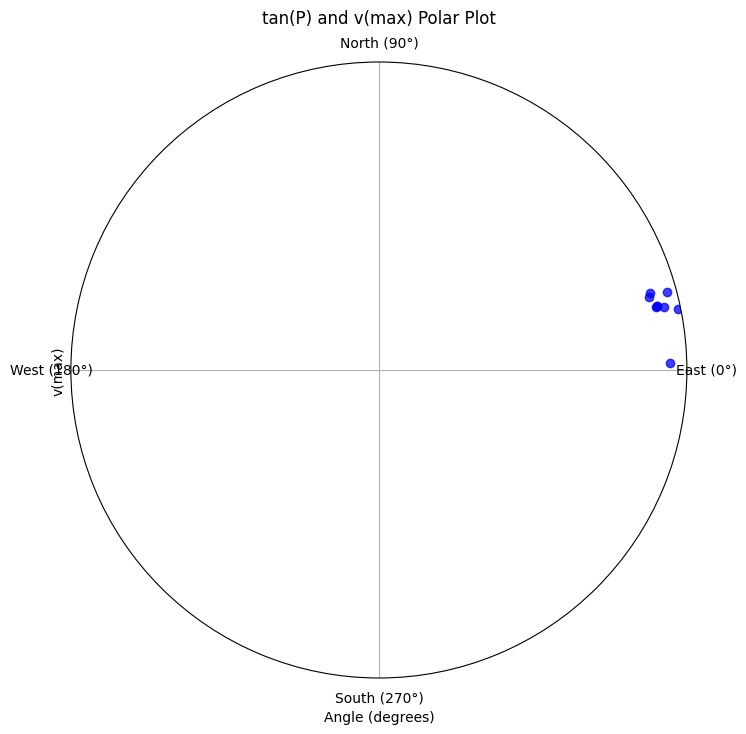

In [109]:
# Load the data with tan(P) and v(max) values
data = pd.read_csv("tanP_vmax_ribose_backbone.csv")

# Convert tan(P) to degrees and calculate the radius
data['Angle (degrees)'] = np.degrees(np.arctan(data['tan(P)']))
data['Angle (degrees)'] = data['Angle (degrees)'] % 360  # Ensure angles are within 0-360 range
data['v(max)'] = data['v(max)']

# Create a polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Plot the data
theta = np.radians(data['Angle (degrees)'])
r = data['v(max)']
ax.scatter(theta, r, c='b', label='tan(P) vs. v(max)', alpha=0.75)

# Set the cardinal direction labels
ax.set_xticks(np.radians([0, 90, 180, 270]))
ax.set_xticklabels(['East (0°)', 'North (90°)', 'West (180°)', 'South (270°)'])

# Add axis labels
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('v(max)')

# Set the range for the radius
ax.set_ylim(0, max(r) * 1.1)

# Add grid lines and a title
ax.grid(True)
ax.set_title('tan(P) and v(max) Polar Plot', va='bottom')

# Show the plot
plt.show()


Based on teh tan(P) and v(max) values, returns whether the rna structure is C3'-endo ro C2'-endo

NEED TO FIX
* Code should return either C3'endo or C2'endo

In [110]:
# Load the data with tan(P) and v(max) values
data = pd.read_csv("tanP_vmax_ribose_backbone.csv")

# Define classification function based on tan(P) and v(max) values
def classify_conformation(row):
    tan_p = row['tan(P)']
    vmax = row['v(max)']
    
    # Set the criteria for classification
    if tan_p > 0 and vmax > threshold_for_C3:
        return "C3'-endo"
    elif tan_p < 0 and vmax <= threshold_for_C2:
        return "C2'-endo"
    else:
        return "Unknown"  # If it doesn't meet either criteria clearly

# Define thresholds (example values, adjust based on your analysis of data or paper)
threshold_for_C3 = 35  # Placeholder, set an appropriate threshold based on paper
threshold_for_C2 = 25  # Placeholder, set an appropriate threshold based on paper

# Apply the classification function to each row
data['Conformation'] = data.apply(classify_conformation, axis=1)

# Display a preview of the results
data[['Residue', 'Chain', 'tan(P)', 'v(max)', 'Conformation']].head()


,Residue,Chain,tan(P),v(max),Conformation
0,1,A,-1.643804,-259.180615,C2'-endo
1,2,A,-1.513361,-262.768583,C2'-endo
2,3,A,-1.522580,-260.303658,C2'-endo
3,4,A,0.230010,-143.147917,Unknown
4,5,A,0.271069,-149.607703,Unknown


In [111]:
# Display the table preview in the notebook
C_endo_preview = data[['Residue', 'Chain', 'tan(P)', 'v(max)', 'Conformation']]
C_endo_preview.head()  # Preview in the notebook

# Save to a CSV file for the full dataset
C_endo_data = "C_endo_data"
data.to_csv(C_endo_data, index=False)

print(f"The ribose backbone conformation data saved to {C_endo_data}")


The ribose backbone conformation data saved to C_endo_data


Step 1: Update Dihedral Calculation Code with X Angle

In [112]:
# Function to calculate the dihedral angle between four points
def dihedral(p1, p2, p3, p4):
    b1 = p2 - p1
    b2 = p3 - p2
    b3 = p4 - p3
    
    # Normalize b2 to avoid influence on angle magnitude
    b2 /= np.linalg.norm(b2)
    
    # Project b1 and b3 perpendicular to b2
    v = b1 - np.dot(b1, b2) * b2
    w = b3 - np.dot(b3, b2) * b2
    
    # Calculate the dihedral angle
    x = np.dot(v, w)
    y = np.dot(np.cross(b2, v), w)
    return np.degrees(np.arctan2(y, x))

# Define sets of purine and pyrimidine residues
purines = {'A', 'G'}
pyrimidines = {'C', 'U'}

# Extract phosphate backbone dihedral angles and X angle for each residue
phosphate_dihedrals_data = []
for model in structure:
    for chain in model:
        residues = list(chain)  # Get residues as a list for easier indexing
        
        for i in range(1, len(residues) - 1):  # Skip first and last for next/previous access
            residue = residues[i]
            try:
                # Define atoms for each dihedral angle (α, β, γ, ε, ζ)
                # (previous code for α, β, γ, ε, ζ calculations here)
                
                # Determine base type and calculate X angle
                res_name = residue.resname.strip()
                if res_name in purines:
                    # X angle for purines: O4' - C1' - N9 - C4
                    p1_x = residue["O4'"].coord
                    p2_x = residue["C1'"].coord
                    p3_x = residue["N9"].coord
                    p4_x = residue["C4"].coord
                    x_angle = dihedral(p1_x, p2_x, p3_x, p4_x)
                elif res_name in pyrimidines:
                    # X angle for pyrimidines: O4' - C1' - N1 - C2
                    p1_x = residue["O4'"].coord
                    p2_x = residue["C1'"].coord
                    p3_x = residue["N1"].coord
                    p4_x = residue["C2"].coord
                    x_angle = dihedral(p1_x, p2_x, p3_x, p4_x)
                else:
                    x_angle = None  # In case residue type is unknown
                
                # Append the results
                phosphate_dihedrals_data.append({
                    "Residue": residue.id[1],
                    "Chain": chain.id,
                    "α": alpha_angle,
                    "β": beta_angle,
                    "γ": gamma_angle,
                    "ε": epsilon_angle,
                    "ζ": zeta_angle,
                    "X angle": x_angle,
                    "X type": "Purine" if res_name in purines else "Pyrimidine"
                })
                
            except KeyError:
                # Skip residues missing any required atoms for these calculations
                continue

# Convert to DataFrame and display a preview
phosphate_dihedrals_df = pd.DataFrame(phosphate_dihedrals_data)
phosphate_dihedrals_df.head()  # Display the first few rows to preview


NameError: name 'alpha_angle' is not defined

In [ ]:
# Save the complete data to a CSV file
csv_file_path = "phosphate_backbone_dihedrals_with_x_angle.csv"
phosphate_dihedrals_df.to_csv(csv_file_path, index=False)

print(f"Phosphate backbone dihedral angles and X angle data saved to {csv_file_path}")


In [ ]:
# Load tan(P) and v(max) data to identify sugar pucker
data = pd.read_csv("tphosphate_backbone_dihedrals_with_x_angle.csv")

# Determine sugar pucker type from tan(P) and v(max)
def classify_sugar_pucker(row):
    tan_p = row['tan(P)']
    vmax = row['v(max)']
    if tan_p > 0:
        return "C3'-endo"  # A-form characteristic
    else:
        return "C2'-endo"  # B-form characteristic

# Add sugar pucker classification
data['Sugar Pucker'] = data.apply(classify_sugar_pucker, axis=1)

# Calculate the helical twist and pitch
def calculate_helical_properties(structure):
    twist_angles = []
    z_coords = []

    for model in structure:
        for chain in model:
            # Collect Z-coordinates of base pair atoms for pitch calculation
            for residue in chain:
                try:
                    z_coords.append(residue['P'].coord[2])  # Assuming P atom represents base height
                except KeyError:
                    continue
            
            # Calculate helical twist between consecutive base pairs
            for i in range(len(z_coords) - 1):
                z_diff = z_coords[i + 1] - z_coords[i]
                twist_angles.append(abs(np.degrees(np.arccos(z_diff / np.linalg.norm(z_diff)))))
    
    # Calculate average pitch and twist per base pair
    pitch = np.mean(np.diff(z_coords))
    twist = np.mean(twist_angles)
    return pitch, twist

# Calculate helical pitch and twist for the loaded structure
pitch, twist = calculate_helical_properties(structure)

# Determine helix type based on pitch, twist, and sugar pucker
def classify_helix_type(data, pitch, twist):
    # Criteria thresholds (approximate values)
    A_FORM_PITCH_THRESHOLD = 30  # Å
    A_FORM_TWIST_THRESHOLD = 33  # degrees
    B_FORM_PITCH_THRESHOLD = 34  # Å
    B_FORM_TWIST_THRESHOLD = 34.3  # degrees

    # Check sugar pucker types
    is_c3_endo = (data['Sugar Pucker'] == "C3'-endo").sum() > (len(data) / 2)
    is_c2_endo = (data['Sugar Pucker'] == "C2'-endo").sum() > (len(data) / 2)
    
    # Determine helix type based on combined features
    if is_c3_endo and pitch <= A_FORM_PITCH_THRESHOLD and twist <= A_FORM_TWIST_THRESHOLD:
        return "A-form helix (RNA)"
    elif is_c2_endo and pitch >= B_FORM_PITCH_THRESHOLD and twist >= B_FORM_TWIST_THRESHOLD:
        return "B-form helix (DNA)"
    else:
        return "Unknown helix type"

# Classify the helix type
helix_type = classify_helix_type(data, pitch, twist)
print(f"The model is classified as: {helix_type}")
